# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Answer:** The data represent 17 marketing campaigns!

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [510]:
#All declarations used in code
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

In [511]:
df       = pd.read_csv('data/bank-additional-full.csv', sep = ';')
df_small = pd.read_csv('data/bank-additional.csv',      sep = ';')

In [512]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



**Answer:** There are some columns with value "unknown" - which in fact are missing values. For now these values will be used. After review of feature importance, author will decide which featrues to drop. Alsow feture "druation" will be dropt because it cannot be used in predictive model.

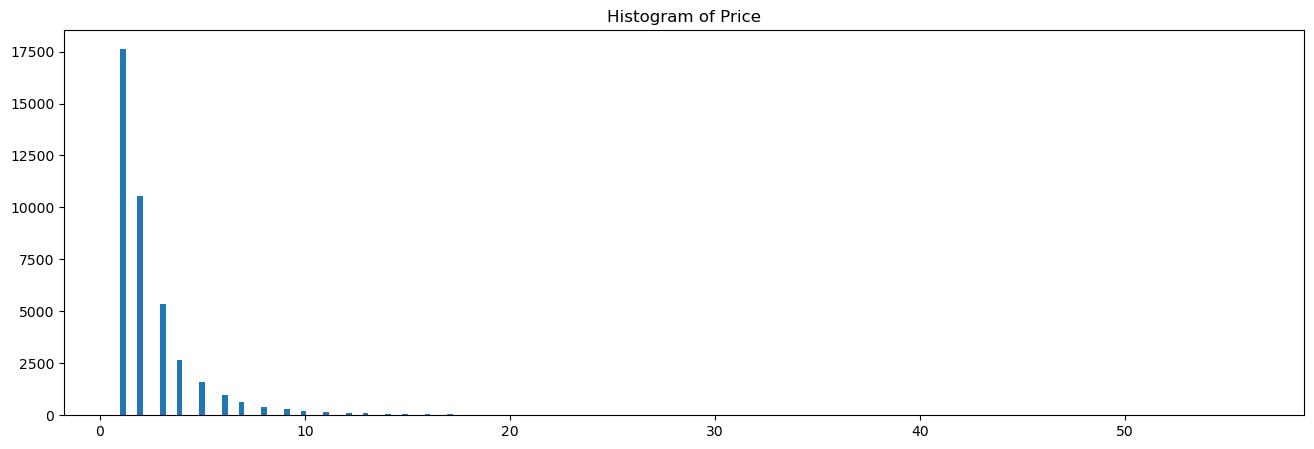

In [513]:
plt.figure(figsize=(16,5))
plt.hist(df_prep['campaign'], bins=200)
plt.title('Histogram of Price')
plt.show()

In [514]:
#Get value information for each column

#for col in df.columns:
#    print(df[col].value_counts(dropna=False))
#    print() 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Answer:** The objective is to create a predictive model with high accuracy which can predict if particular contact will accept the offer or not. Then this model will be used to filter future call contacts.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [515]:
#Convert target label for both data sets
y = df['y'].map({"yes":1, "no":0})
y_small = df_small['y'].map({"yes":1, "no":0})

#Create list of the bank information features
df_bank_features = ['age','job','marital','education','default','housing','loan']

In [516]:
#Convert dataset so that it can be used for modeling
selector_obj_1 = make_column_selector(dtype_include=object)
transformer_1 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), selector_obj_1),
    remainder = StandardScaler()
)

X1 = pd.DataFrame(transformer_1.fit_transform(df[df_bank_features]), columns=transformer_1.get_feature_names_out())
X1.head(3)

,onehotencoder__job_admin.,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,...,onehotencoder__default_no,onehotencoder__default_unknown,onehotencoder__default_yes,onehotencoder__housing_no,onehotencoder__housing_unknown,onehotencoder__housing_yes,onehotencoder__loan_no,onehotencoder__loan_unknown,onehotencoder__loan_yes,remainder__age
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.533034
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.628993
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.290186


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [517]:
#Split the data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, random_state = 17)

In [518]:
X1_train.shape

(30891, 34)

In [519]:
X1_test.shape

(10297, 34)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

***Answer:*** Baseline accuracy is: 0.8832669709624162

In [520]:
#Calculate baseline accuracy using DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X1_train, y1_train)

baseline_accuracy = dummy.score(X1_test, y1_test)

print(f"Baselilne accuracy: {baseline_accuracy}")

Baselilne accuracy: 0.8832669709624162


In [521]:
#Calculate baseline accuracy using proportion of the largest class
print(f"Baselilne accuracy: {y1_test.value_counts().max() / len(y1_test)}")

Baselilne accuracy: 0.8832669709624162


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [522]:
#Basic Logistic Regression model with bank information features
start = time.time()
lr = LogisticRegression(random_state=17, max_iter=1000)
lr.fit(X1_train, y1_train)
end = time.time()
time_lr = end-start

### Problem 9: Score the Model

What is the accuracy of your model?

In [523]:
#Accuracy of the basic LogisticRegression model
score_train_lr = lr.score(X1_train, y1_train)
score_test_lr = lr.score(X1_test, y1_test)
print(f"The accuracy of the simple logistic regression model is {score_test_lr}")

The accuracy of the simple logistic regression model is 0.8832669709624162


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [524]:
#DecisionTreeClassifier model with criterion=entropy
start = time.time()
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X1_train, y1_train)
end = time.time()
time_dtree = end-start

score_train_dtree = dtree.score(X1_train, y1_train)
score_test_dtree  = dtree.score(X1_test, y1_test)

print(score_test_dtree)

0.8636496066815578


In [525]:
#KNeighborsClassifier model with n_neighbors=5
start = time.time()
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X1_train, y1_train)
end = time.time()
time_knc = end-start

score_train_knc = knc.score(X1_train, y1_train)
score_test_knc  = knc.score(X1_test, y1_test)

print(score_test_knc)

0.8726813635039332


In [526]:
#SVC model with kernel=rbf
start = time.time()
svc = SVC(kernel='rbf')
svc.fit(X1_train, y1_train)
end = time.time()
time_svc = end-start

score_train_svc = svc.score(X1_train, y1_train)
score_test_svc  = svc.score(X1_test, y1_test)

print(score_test_svc)

0.8834612022919297


In [564]:
total_fit_time = pd.DataFrame({
    "Model (simple approach)" : ['LogisticRegression','DecisionTreeClassifier (criterion=entropy)','KNeighborsClassifier (n_neighbors=5)','SVC (kernel=rbf)'],
    "Train Time" : [time_lr, time_dtree, time_knc, time_svc],
    "Train Accuracy" : [score_train_lr, score_train_dtree, score_train_knc, score_train_svc],
    "Test Accuracy" : [score_test_lr, score_test_dtree, score_test_knc, score_test_svc]
})

total_fit_time = total_fit_time.set_index('Model (simple approach)')
total_fit_time

,Train Time,Train Accuracy,Test Accuracy
Model (simple approach),,,
LogisticRegression,0.062624,0.888705,0.883267
DecisionTreeClassifier (criterion=entropy),38.614394,0.918714,0.863650
KNeighborsClassifier (n_neighbors=5),0.006999,0.891781,0.872681
SVC (kernel=rbf),55.813455,0.889482,0.883461


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Prepare training and testing datasets

In [528]:
#X2 dataset will be used in training
X2 = df.drop(['y','duration'], axis=1)
X2.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [529]:
#X2_small will be used in cases when X2 is to big for training
X2_small = df_small.drop(['y','duration'], axis=1)
X2_small.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1


In [530]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state = 17)

In [531]:
X2_small_train, X2_small_test, y2_small_train, y2_small_test = train_test_split(X2_small, y_small, random_state = 17)

In [568]:
selector_obj_2 = make_column_selector(dtype_include=object)
transformer_2 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), selector_obj_2),
    remainder = StandardScaler()
)
#Will be used in some cases to train model or get transformed feature names
X2_train_transformed_df = pd.DataFrame(transformer_2.fit_transform(X2_train), columns=transformer_2.get_feature_names_out())
X2_test_transformed_df  = pd.DataFrame(transformer_2.transform(X2_test), columns=transformer_2.get_feature_names_out())

X2_small_train_transformed_df = pd.DataFrame(transformer_2.transform(X2_small_train), columns=transformer_2.get_feature_names_out())
X2_small_test_transformed_df  = pd.DataFrame(transformer_2.transform(X2_small_test), columns=transformer_2.get_feature_names_out())

#### LogisticRegression

***Result:*** Two LogisticRegression models were created. Both used the large dataset. First used subset of features, second used all features. Author decieded to use 30 best features for first test. Best model was the one with 30 featues - accuracy socre: 0.8981256676701952

In [543]:
transformer_3 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), make_column_selector(dtype_include=object)),
    remainder = StandardScaler()
)

model_lr = LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 17)
extractor = SelectFromModel(model_lr, max_features=30)

pipe2_lr = Pipeline([
    ('transformer', transformer_3),
    ('extractor', extractor),
    ('lr', LogisticRegression(random_state=17, max_iter=1000))
])

pipe2_lr.fit(X2_train, y2_train)

pipe2_lr_score = pipe2_lr.score(X2_test, y2_test)
print(f"Accuracy score for LogisticRegression model with feature selection {pipe2_lr_score}")

Accuracy score for LogisticRegression model with feature selection 0.8981256676701952


In [544]:
feature_names = X2_train_transformed_df.columns[pipe2_lr.named_steps['extractor'].get_support()]
print(f"Number of features selected {len(feature_names)}")
print(f"Feature names selected: {feature_names}")

Number of features selected 30
Feature names selected: Index(['onehotencoder__job_retired', 'onehotencoder__job_student',
       'onehotencoder__job_unemployed', 'onehotencoder__marital_divorced',
       'onehotencoder__marital_married', 'onehotencoder__education_basic.4y',
       'onehotencoder__education_basic.9y',
       'onehotencoder__education_high.school',
       'onehotencoder__default_unknown', 'onehotencoder__housing_unknown',
       'onehotencoder__contact_telephone', 'onehotencoder__month_aug',
       'onehotencoder__month_dec', 'onehotencoder__month_jun',
       'onehotencoder__month_mar', 'onehotencoder__month_may',
       'onehotencoder__month_nov', 'onehotencoder__month_sep',
       'onehotencoder__day_of_week_fri', 'onehotencoder__day_of_week_mon',
       'onehotencoder__day_of_week_wed', 'onehotencoder__poutcome_failure',
       'onehotencoder__poutcome_nonexistent', 'remainder__campaign',
       'remainder__pdays', 'remainder__emp.var.rate',
       'remainder__cons.p

In [545]:
transformer_4 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), make_column_selector(dtype_include=object)),
    remainder = StandardScaler()
)

pipe2_lr2 = Pipeline([
    ('transformer', transformer_4),
    ('lr', LogisticRegression(random_state=17, max_iter=1000))
])

pipe2_lr2.fit(X2_train, y2_train)

pipe2_lr2_score = pipe2_lr2.score(X2_test, y2_test)
print(f"Accuracy score for LogisticRegression model {pipe2_lr2_score}")

Accuracy score for LogisticRegression model 0.8980285520054385


#### This section displays most importat features in graph

In [546]:
Cs = np.logspace(-4, 0.1)
coef_list = []
for c in Cs:
    lr = LogisticRegression(C=c, penalty="l1", solver="liblinear", random_state=17, max_iter=1000)
    lr.fit(X2_train_transformed_df, y2_train)
    coef_list.append(lr.coef_[0])

coef_df = pd.DataFrame(coef_list, columns=transformer_4.get_feature_names_out())
coef_df['Cs'] = Cs
coef_df = coef_df.set_index("Cs")

In [547]:
coef_df.head(10)

,onehotencoder__job_admin.,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,...,onehotencoder__poutcome_success,remainder__age,remainder__campaign,remainder__pdays,remainder__previous,remainder__emp.var.rate,remainder__cons.price.idx,remainder__cons.conf.idx,remainder__euribor3m,remainder__nr.employed
Cs,,,,,,,,,,,,,,,,,,,,,
0.000100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
0.000385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.004652,0.0,0.0,0.0,0.0,0.0,-0.108788
0.000467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.065316,0.0,0.0,0.0,0.0,0.0,-0.199913


In [548]:
#Few most important featues - feature selection will be used later
print(coef_df.iloc[[21],0])
coef_df_melted = coef_df.iloc[[21],:].melt().query('value!=0')
coef_df_melted['value'] = coef_df_melted['value'].abs()
coef_df_melted = coef_df_melted.sort_values('value', ascending=False)
coef_df_melted

Cs
0.005717    0.0
Name: onehotencoder__job_admin., dtype: float64


,variable,value
60,remainder__nr.employed,0.663817
40,onehotencoder__month_may,0.588209
54,remainder__pdays,0.256745
33,onehotencoder__contact_telephone,0.081731
56,remainder__emp.var.rate,0.080595
53,remainder__campaign,0.021249
55,remainder__previous,0.016844
58,remainder__cons.conf.idx,0.010130


Text(0.5, 0, 'Increasing 1/C')

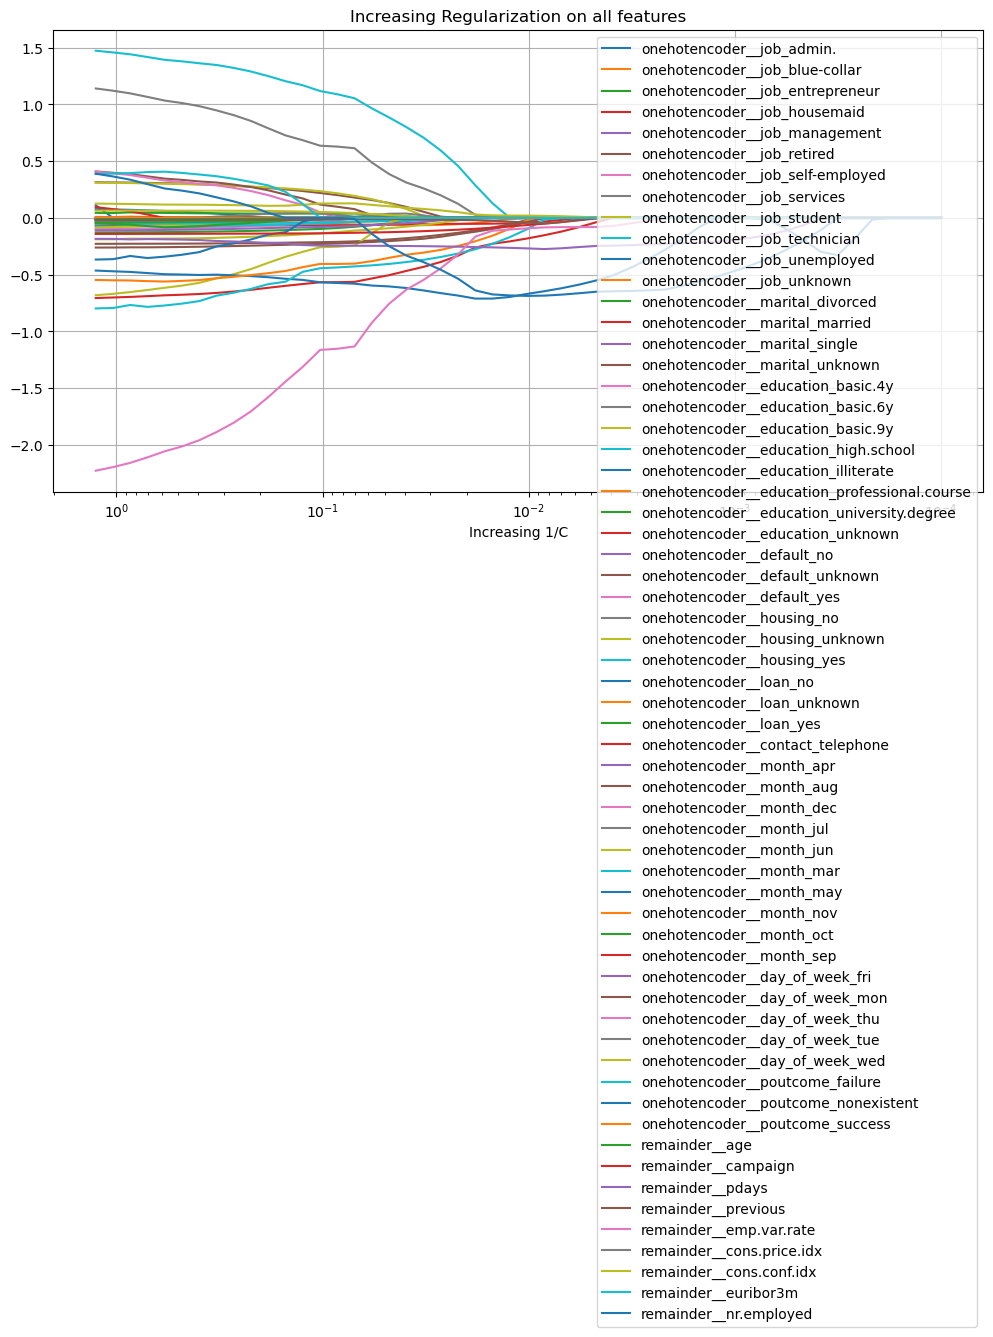

In [549]:
plt.figure(figsize = (12, 6))
plt.semilogx(coef_df)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(list(coef_df.columns));
plt.title('Increasing Regularization on all features')
plt.xlabel("Increasing 1/C")

#### Decision Trees with GridSearchCV

***Result:*** Best DecisionTreeClassifier model:
- Accuracy: 0.896086238710304
- Parameters: 
{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 13,
 'min_samples_split': 6}

GridSearchCV with DecisionTreeClassifier did 3780 tests and took 427.60 seconds to complete.

In [553]:
transformer_5 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), make_column_selector(dtype_include=object)),
    remainder = StandardScaler()
)

params = {'max_depth': [5,6,7,8,9,10],
         'min_samples_split': [4,5,6,7,8,9,10],
          'criterion': ['gini','entropy'],
          'min_samples_leaf': [8,9,10,11,12,13,14,15,16]
         }

dtree = DecisionTreeClassifier()
gscv = GridSearchCV(dtree, params, cv=5, verbose=1)

pipe3_dtree = Pipeline([
    ('transformer', transformer_5),
    ('gscv', gscv)
])

start = time.time()
pipe3_dtree.fit(X2_train, y2_train)
end = time.time()
time_dtree = end-start

print(f"Exection time {time_dtree}")

pipe3_dtree_score = pipe3_dtree.score(X2_test, y2_test)
pipe3_dtree_score

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
Exection time 427.6084990501404


0.896086238710304

In [554]:
pipe3_dtree.named_steps['gscv'].best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 13,
 'min_samples_split': 6}

#### KNeighborsClassifier with GridSearchCV

***Result:*** Best KNeighborsClassifier model:
- Accuracy: 0.9048543689320389
- Parameters: {'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'uniform'}

GridSearchCV with KNeighborsClassifier did 420 tests and took 10.32 seconds to complete.

In [585]:
transformer_6 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), make_column_selector(dtype_include=object)),
    remainder = StandardScaler()
)

params = {'n_neighbors': range(5, 33, 2),
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean','manhattan','minkowski']
         }

knc = KNeighborsClassifier()
gscv = GridSearchCV(knc, params, cv=5, verbose=1)

pipe4_knc = Pipeline([
    ('transformer', transformer_6),
    ('gscv', gscv)
])

start = time.time()
pipe4_knc.fit(X2_small_train, y2_small_train)
end = time.time()
time_dtree = end-start

print(f"Exection time {time_dtree}")

pipe4_knc_score = pipe4_knc.score(X2_small_test, y2_small_test)
pipe4_knc_score

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Exection time 10.213258266448975


0.9048543689320389

In [586]:
pipe4_knc.named_steps['gscv'].best_params_

{'metric': 'manhattan', 'n_neighbors': 31, 'weights': 'uniform'}

#### SVC with GridSearchCV

***Result:*** Best SVC model (with small dataset):
- Accuracy: 0.9048543689320389
- Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

GridSearchCV with SVC did 150 fits and took 38.84 seconds to complete.

In [558]:
transformer_7 = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='if_binary'), make_column_selector(dtype_include=object)),
    remainder = StandardScaler()
)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cv_scores = []
for k in kernels:
    svc = SVC(kernel=k)
    scores = cross_val_score(svc, transformer_7.fit_transform(X2_small_train), y2_small_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernel is {optimal_kernel} with cross-validation score of {max(cv_scores)}")

Optimal kernel is rbf with cross-validation score of 0.8970511872354487


In [565]:
params = {'C': [0.01, 0.1, 1, 10, 100],
          'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
          'kernel': ['rbf'] #['rbf','linear','poly', 'sigmoid']
         }

svc = SVC()
gscv = GridSearchCV(svc, params, cv=5, verbose=1)

pipe5_svc = Pipeline([
    ('transformer', transformer),
    ('gscv', gscv)
])

start = time.time()
pipe5_svc.fit(X2_small_train, y2_small_train)
end = time.time()
time_dtree = end-start

print(f"Exection time {time_dtree}")

pipe5_svc_score = pipe5_svc.score(X2_small_test, y2_small_test)
pipe5_svc_score

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Exection time 38.838906049728394


0.9048543689320389

In [566]:
pipe5_svc.named_steps['gscv'].best_params_


{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

#### SVC with GridSearchCV and limited number of features

***Result:*** Best SVC model (with small dataset and best at least 20 features):
- Accuracy for small dataset: 0.9048543689320389
- Accuracy for large dataset: 0.8983198989997087
- Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

GridSearchCV with SVC took 23.19 seconds to complete.

In [380]:
result = []
for index, row in coef_df.iterrows():
    non_zero_cols = row[row != 0].index.tolist()
    col_count = len(non_zero_cols)
    if (col_count > 0):
        result.append([index, col_count, non_zero_cols])
        #print(f"Row {index} {col_count}: {non_zero_cols}")

In [381]:
coef_df2 = pd.DataFrame(result, columns=['Cs','Count','Columns'])

In [581]:
#Will take at least 20 features because in document it was said that they took 30

In [575]:
best_score = 0

for index, row in coef_df.iterrows():
    non_zero_cols = row[row != 0].index.tolist()
    col_count = len(non_zero_cols)
    if (col_count > 20):

        params = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
              'kernel': ['rbf'] #['rbf','linear','poly', 'sigmoid']
             }
    
        svc = SVC()
        gscv = GridSearchCV(svc, params, cv=3, verbose=0)
    
        pipe5_svc = Pipeline([
            ('gscv', gscv)
        ])
    
        start = time.time()
        pipe5_svc.fit(X2_small_train_transformed_df[non_zero_cols], y2_small_train)
        end = time.time()
        time_svc = end-start
    
        pipe5_svc_score = pipe5_svc.score(X2_small_test_transformed_df[non_zero_cols], y2_small_test)

        if (pipe5_svc_score > best_score):
            best_score = pipe5_svc_score
            
            print(non_zero_cols)
            print(pipe5_svc.named_steps['gscv'].best_params_)
            print(f"Execution time: {time_svc}")
            print(pipe5_svc_score)
            print()
        


['onehotencoder__job_blue-collar', 'onehotencoder__job_retired', 'onehotencoder__marital_married', 'onehotencoder__education_basic.9y', 'onehotencoder__default_unknown', 'onehotencoder__housing_yes', 'onehotencoder__contact_telephone', 'onehotencoder__month_jul', 'onehotencoder__month_mar', 'onehotencoder__month_may', 'onehotencoder__month_nov', 'onehotencoder__day_of_week_fri', 'onehotencoder__day_of_week_mon', 'onehotencoder__poutcome_failure', 'remainder__campaign', 'remainder__pdays', 'remainder__previous', 'remainder__emp.var.rate', 'remainder__cons.price.idx', 'remainder__cons.conf.idx', 'remainder__nr.employed']
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Execution time: 19.979728937149048
0.903883495145631

['onehotencoder__job_blue-collar', 'onehotencoder__job_retired', 'onehotencoder__job_student', 'onehotencoder__marital_divorced', 'onehotencoder__marital_married', 'onehotencoder__education_basic.4y', 'onehotencoder__education_basic.9y', 'onehotencoder__education_high.school'

In [577]:
best_features = ['onehotencoder__job_blue-collar', 'onehotencoder__job_retired', 'onehotencoder__job_student', 
                 'onehotencoder__marital_divorced', 'onehotencoder__marital_married', 'onehotencoder__education_basic.4y', 
                 'onehotencoder__education_basic.9y', 'onehotencoder__education_high.school', 'onehotencoder__education_university.degree', 
                 'onehotencoder__default_unknown', 'onehotencoder__housing_yes', 'onehotencoder__loan_yes', 
                 'onehotencoder__contact_telephone', 'onehotencoder__month_aug', 'onehotencoder__month_jul', 
                 'onehotencoder__month_jun', 'onehotencoder__month_mar', 'onehotencoder__month_may', 
                 'onehotencoder__month_nov', 'onehotencoder__day_of_week_fri', 'onehotencoder__day_of_week_mon', 
                 'onehotencoder__day_of_week_wed', 'onehotencoder__poutcome_failure', 'remainder__campaign', 
                 'remainder__pdays', 'remainder__previous', 'remainder__emp.var.rate', 'remainder__cons.price.idx', 'remainder__cons.conf.idx']


In [587]:
#Without unknown features
best_features2 = ['onehotencoder__job_blue-collar', 'onehotencoder__job_retired', 'onehotencoder__job_student', 
                 'onehotencoder__marital_divorced', 'onehotencoder__marital_married', 'onehotencoder__education_basic.4y', 
                 'onehotencoder__education_basic.9y', 'onehotencoder__education_high.school', 'onehotencoder__education_university.degree', 
                 'onehotencoder__housing_yes', 'onehotencoder__loan_yes', 
                 'onehotencoder__contact_telephone', 'onehotencoder__month_aug', 'onehotencoder__month_jul', 
                 'onehotencoder__month_jun', 'onehotencoder__month_mar', 'onehotencoder__month_may', 
                 'onehotencoder__month_nov', 'onehotencoder__day_of_week_fri', 'onehotencoder__day_of_week_mon', 
                 'onehotencoder__day_of_week_wed', 'onehotencoder__poutcome_failure', 'remainder__campaign', 
                 'remainder__pdays', 'remainder__previous', 'remainder__emp.var.rate', 'remainder__cons.price.idx', 'remainder__cons.conf.idx']

In [579]:
print(len(best_features2))

28


In [583]:
#Create model with best 28 features using land and also small dataset

In [580]:
start = time.time()
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X2_train_transformed_df[best_features2], y2_train)
end = time.time()
time_svc = end-start

score_train_svc = svc.score(X2_train_transformed_df[best_features2], y2_train)
score_test_svc  = svc.score(X2_test_transformed_df[best_features2], y2_test)

print(f"Execution time: {time_svc}")
print(score_train_svc)
print(score_test_svc)

Execution time: 30.607914686203003
0.9000032371888252
0.8983198989997087


In [582]:
start = time.time()
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X2_small_train_transformed_df[best_features2], y2_small_train)
end = time.time()
time_svc = end-start

score_train_svc = svc.score(X2_small_train_transformed_df[best_features2], y2_small_train)
score_test_svc  = svc.score(X2_small_test_transformed_df[best_features2], y2_small_test)

print(f"Execution time: {time_svc}")
print(score_train_svc)
print(score_test_svc)

Execution time: 0.21044588088989258
0.9028811913240531
0.9048543689320389


### Questions

In [576]:
#What to do with numeric features? They did not look very good for using in a model!